**Import packages**

In [ ]:
!pip install pytictoc

In [ ]:
!pip install tensorflow

In [ ]:
import random
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pytictoc import TicToc
warnings.filterwarnings( "ignore" )

**Load the dataset**

In [ ]:
(X_train, y_train), (X_test,y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

**Create helper functions**

In [ ]:
def plot_sample_image(X, y):
    plt.figure(figsize = (15,2))
    plt.imshow(X)
    classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    plt.xlabel('Image Label: {}'.format(classes[y]))

def classification_results(X_test,y_test,y_pred_classes):
  from sklearn.metrics import confusion_matrix , classification_report
  import seaborn as sn

  cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_classes)
  plt.figure(figsize = (7,5))
  sn.heatmap(cm, annot=True, fmt='d', cmap='Greens')
  plt.xlabel('Predicted');
  plt.ylabel('Truth');

  print("Classification Report: \n", classification_report(y_test, y_pred_classes))

def plot_fitting_history(history,filename,dpi):
  epochs = len(history.history['loss'])
  epoch_data = np.arange(1,epochs+1)
  plt.plot(epoch_data,history.history['loss'],'o-')
  plt.plot(epoch_data,history.history['val_loss'],'o--')
  plt.ylabel('Loss')
  plt.xlabel('Epoch sequence' )
  plt.xticks(np.arange(0, epochs + 1, step=1))
  plt.legend(['Training','Validation'])
  plt.savefig(filename, dpi=dpi)
  plt.show()

**Plot sample image**

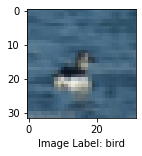

In [ ]:
index = np.random.randint(100)
plot_sample_image(X_train[index], y_train[index])

**Normalize the input data**

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/ECE 696B/Project - ECE696B
%cd /content/gdrive/MyDrive/Colab Notebooks

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks


# Create adversarial examples for training

In [ ]:
indexes = np.arange(0,5000);
noise = np.random.normal(size=X_train[indexes].shape, loc=0.0, scale=0.1)
X_train_noisy_1 = X_train[indexes] + noise
X_train_noisy_1 = np.clip(X_train_noisy_1, 0, 1)

indexes = np.arange(5000,7500);
noise = np.random.normal(size=X_train[indexes].shape, loc=0.0, scale=0.2)
X_train_noisy_2 = X_train[indexes] + noise
X_train_noisy_2 = np.clip(X_train_noisy_2, 0, 1)

indexes = np.arange(7500,8750);
noise = np.random.normal(size=X_train[indexes].shape, loc=0.0, scale=0.3)
X_train_noisy_3 = X_train[indexes] + noise
X_train_noisy_3 = np.clip(X_train_noisy_3, 0, 1)

indexes = np.arange(8750, 9375);
noise = np.random.normal(size=X_train[indexes].shape, loc=0.0, scale=0.4)
X_train_noisy_4 = X_train[indexes] + noise
X_train_noisy_4 = np.clip(X_train_noisy_4, 0, 1)

indexes = np.arange(9375, 10000);
noise = np.random.normal(size=X_train[indexes].shape, loc=0.0, scale=0.5)
X_train_noisy_5 = X_train[indexes] + noise
X_train_noisy_5 = np.clip(X_train_noisy_5, 0, 1)

X_train_noisy = np.concatenate((X_train_noisy_1, X_train_noisy_2, X_train_noisy_3,\
                                X_train_noisy_4, X_train_noisy_5), axis = 0)

indexes = range(10000)
avg_l2_norm = np.mean(np.sqrt(np.sum((X_train_noisy-X_train[indexes])**2, axis=(1,2,3))))
print("Average l2 distance of the perturbation:", avg_l2_norm)

Average l2 distance of the perturbation: 9.223532418718388


In [ ]:
X_train_stack = np.concatenate((X_train, X_train_noisy), axis = 0)
y_train_stack = np.concatenate((y_train, y_train[indexes]), axis = 0)

p = np.random.permutation(len(X_train_stack))
X_train_stack, y_train_stack = X_train_stack[p], y_train_stack[p]

X_train_stack.shape, y_train_stack.shape

((60000, 32, 32, 3), (60000,))

# Adversarial training of Linear model

In [ ]:
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Linear_CIFAR10 = models.Sequential([
        layers.Flatten(input_shape=X_train.shape[1:]),
        layers.Dense(10, activation='softmax'),  
    ])

learning_rate =  0.0001
Linear_CIFAR10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history_C_Linear_GNA = Linear_CIFAR10.fit(X_train_stack, y_train_stack, epochs=200, batch_size=32,
            validation_split = 0.1, callbacks = early_callbacks, verbose=1, shuffle = True)

Epoch 1/200
1688/1688 [==============================] - 5s 3ms/step - loss: 1.9789 - accuracy: 0.2964 - val_loss: 1.8611 - val_accuracy: 0.3427
Epoch 2/200
1688/1688 [==============================] - 5s 3ms/step - loss: 1.8498 - accuracy: 0.3555 - val_loss: 1.7976 - val_accuracy: 0.3778
Epoch 3/200
1688/1688 [==============================] - 5s 3ms/step - loss: 1.8143 - accuracy: 0.3695 - val_loss: 1.7727 - val_accuracy: 0.3830
Epoch 4/200
1688/1688 [==============================] - 4s 3ms/step - loss: 1.7904 - accuracy: 0.3813 - val_loss: 1.7678 - val_accuracy: 0.3802
Epoch 5/200
1688/1688 [==============================] - 5s 3ms/step - loss: 1.7755 - accuracy: 0.3858 - val_loss: 1.7680 - val_accuracy: 0.3793
Epoch 6/200
1688/1688 [==============================] - 5s 3ms/step - loss: 1.7629 - accuracy: 0.3929 - val_loss: 1.7428 - val_accuracy: 0.3957
Epoch 7/200
1688/1688 [==============================] - 4s 3ms/step - loss: 1.7527 - accuracy: 0.3976 - val_loss: 1.7417 - val_ac

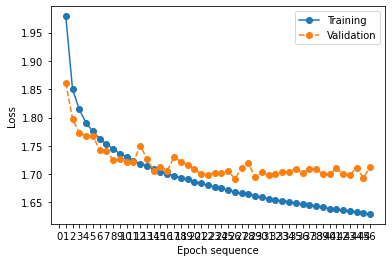

In [ ]:
filename = 'GNA Adversarial Training history CIFAR10 [Linear]'+'.png'
plot_fitting_history(history_C_Linear_GNA, filename, dpi = 100)

313/313 [==============================] - 1s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.52      0.28      0.37      1000
           1       0.45      0.51      0.48      1000
           2       0.36      0.10      0.16      1000
           3       0.36      0.09      0.14      1000
           4       0.30      0.39      0.34      1000
           5       0.27      0.47      0.34      1000
           6       0.42      0.52      0.46      1000
           7       0.44      0.46      0.45      1000
           8       0.43      0.61      0.50      1000
           9       0.43      0.46      0.45      1000

    accuracy                           0.39     10000
   macro avg       0.40      0.39      0.37     10000
weighted avg       0.40      0.39      0.37     10000



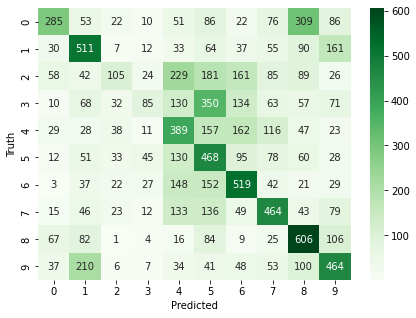

In [ ]:
y_pred = Linear_CIFAR10.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
classification_results(X_test,y_test,y_pred_classes)

In [ ]:
Linear_CIFAR10.save('Linear_CIFAR10_GNA_trained.h5')

# Adversarial training of MLP model

In [ ]:
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

MLP_CIFAR10 = models.Sequential([
        layers.Flatten(input_shape=X_train.shape[1:]),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')    
    ])

learning_rate =  0.0001
MLP_CIFAR10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history_C_MLP_GNA = MLP_CIFAR10.fit(X_train_stack, y_train_stack, epochs=200, batch_size=32,
            validation_split = 0.1, callbacks = early_callbacks, verbose=1, shuffle = True)

Epoch 1/200
1688/1688 [==============================] - 25s 9ms/step - loss: 2.9385 - accuracy: 0.1677 - val_loss: 1.9354 - val_accuracy: 0.2937
Epoch 2/200
1688/1688 [==============================] - 14s 8ms/step - loss: 2.4480 - accuracy: 0.2143 - val_loss: 1.9524 - val_accuracy: 0.2913
Epoch 3/200
1688/1688 [==============================] - 14s 8ms/step - loss: 2.2166 - accuracy: 0.2443 - val_loss: 1.8453 - val_accuracy: 0.3250
Epoch 4/200
1688/1688 [==============================] - 14s 8ms/step - loss: 2.0610 - accuracy: 0.2689 - val_loss: 1.7794 - val_accuracy: 0.3503
Epoch 5/200
1688/1688 [==============================] - 14s 8ms/step - loss: 1.9574 - accuracy: 0.2966 - val_loss: 1.7393 - val_accuracy: 0.3632
Epoch 6/200
1688/1688 [==============================] - 14s 8ms/step - loss: 1.8897 - accuracy: 0.3158 - val_loss: 1.7675 - val_accuracy: 0.3582
Epoch 7/200
1688/1688 [==============================] - 15s 9ms/step - loss: 1.8366 - accuracy: 0.3369 - val_loss: 1.7052 -

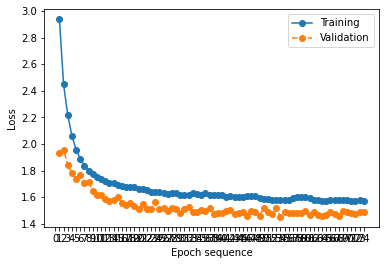

In [ ]:
filename = 'GNA Adversarial Training history CIFAR10 [MLP]'+'.png'
plot_fitting_history(history_C_MLP_GNA, filename, dpi = 100)

313/313 [==============================] - 1s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.50      0.56      0.53      1000
           1       0.49      0.65      0.56      1000
           2       0.31      0.41      0.36      1000
           3       0.40      0.17      0.24      1000
           4       0.41      0.36      0.38      1000
           5       0.49      0.30      0.37      1000
           6       0.47      0.56      0.51      1000
           7       0.52      0.54      0.53      1000
           8       0.63      0.55      0.59      1000
           9       0.48      0.60      0.53      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.46     10000
weighted avg       0.47      0.47      0.46     10000



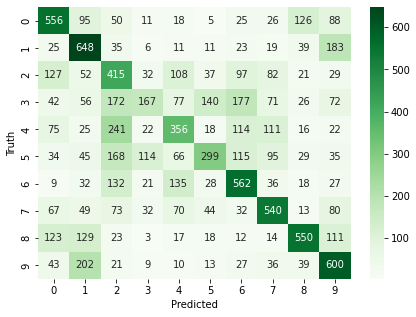

In [ ]:
y_pred = MLP_CIFAR10.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
classification_results(X_test,y_test,y_pred_classes)

In [ ]:
MLP_CIFAR10.save('MLP_CIFAR10_GNA_trained.h5')

# Adversarial training of CNN model

In [ ]:
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

CNN_CIFAR10 = models.Sequential([

    layers.Conv2D(128, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),

    layers.Dense(2048, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(256, activation='relu'), 
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(10, activation='softmax'),
])

learning_rate =  0.0001
CNN_CIFAR10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history_C_CNN_GNA = CNN_CIFAR10.fit(X_train_stack, y_train_stack, epochs=200, batch_size=32,
            validation_split = 0.1, callbacks = early_callbacks, verbose=1, shuffle = True)

Epoch 1/200
1688/1688 [==============================] - 53s 22ms/step - loss: 3.1006 - accuracy: 0.1224 - val_loss: 2.1126 - val_accuracy: 0.1915
Epoch 2/200
1688/1688 [==============================] - 35s 21ms/step - loss: 2.4527 - accuracy: 0.1694 - val_loss: 1.8910 - val_accuracy: 0.2653
Epoch 3/200
1688/1688 [==============================] - 37s 22ms/step - loss: 2.1378 - accuracy: 0.2163 - val_loss: 1.7965 - val_accuracy: 0.2990
Epoch 4/200
1688/1688 [==============================] - 36s 21ms/step - loss: 1.9185 - accuracy: 0.2756 - val_loss: 1.5994 - val_accuracy: 0.3763
Epoch 5/200
1688/1688 [==============================] - 36s 21ms/step - loss: 1.7360 - accuracy: 0.3382 - val_loss: 1.4969 - val_accuracy: 0.4360
Epoch 6/200
1688/1688 [==============================] - 36s 22ms/step - loss: 1.6044 - accuracy: 0.3937 - val_loss: 1.3725 - val_accuracy: 0.4982
Epoch 7/200
1688/1688 [==============================] - 37s 22ms/step - loss: 1.4504 - accuracy: 0.4623 - val_loss: 1

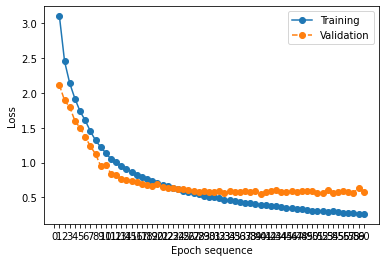

In [ ]:
filename = 'GNA Adversarial Training history CIFAR10 [CNN]'+'.png'
plot_fitting_history(history_C_CNN_GNA, filename, dpi = 100)

313/313 [==============================] - 2s 4ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      1000
           1       0.93      0.91      0.92      1000
           2       0.78      0.75      0.76      1000
           3       0.70      0.72      0.71      1000
           4       0.83      0.83      0.83      1000
           5       0.78      0.77      0.78      1000
           6       0.85      0.92      0.88      1000
           7       0.90      0.86      0.88      1000
           8       0.91      0.91      0.91      1000
           9       0.90      0.92      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



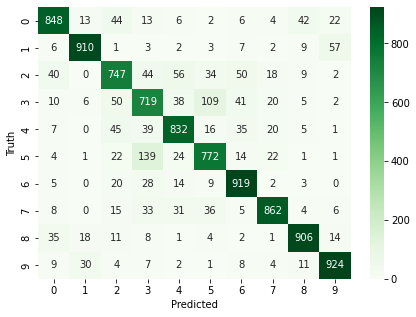

In [ ]:
y_pred = CNN_CIFAR10.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
classification_results(X_test,y_test,y_pred_classes)

In [ ]:
CNN_CIFAR10.save('CNN_CIFAR10_GNA_trained.h5')

# Evaluate performance of adversarial training

**Evaluate performance on unperturbed data**

In [ ]:
%cd C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B
from keras.models import load_model
Linear_CIFAR10 = load_model('Linear_CIFAR10_GNA_trained.h5')
MLP_CIFAR10 = load_model('MLP_CIFAR10_GNA_trained.h5')
CNN_CIFAR10 = load_model('CNN_CIFAR10_GNA_trained.h5')

C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B


In [ ]:
%cd C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\GNA

C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\GNA


In [ ]:
indexes = range(1000)
print('Test accuracy on unperturbed data')
Linear_CIFAR10.evaluate(X_test[indexes],y_test[indexes])
MLP_CIFAR10.evaluate(X_test[indexes],y_test[indexes])
CNN_CIFAR10.evaluate(X_test[indexes],y_test[indexes])
print()

Test accuracy on unperturbed data
32/32 [==============================] - 2s 66ms/step - loss: 0.5191 - accuracy: 0.8540



**Evaluate performance on perturbed data**

In [ ]:
sigmas = np.arange(0,1.1,0.1)
stored_results = []
for i in sigmas:
  print(f'Sigma value: {np.round(i,1)}')
  stored_results.append(i)
    
  filename = 'CIFAR10_X_test_noisy_GNA_sigma' + str(np.round(i,1)) + '.npy'
  X_test_noisy = np.load(filename)
  
  avg_l2_norm = np.mean(np.sqrt(np.sum((X_test_noisy-X_test[indexes])**2, axis=(1,2,3))))
  stored_results.append(avg_l2_norm)
  print("Average l2 distance of the perturbation:", avg_l2_norm)

  print('\nTest accuracy on perturbed data')
  _,Linear_CIFAR10_test_accuray = Linear_CIFAR10.evaluate(X_test_noisy,y_test[indexes])
  stored_results.append(Linear_CIFAR10_test_accuray)

  _,MLP_CIFAR10_test_accuray = MLP_CIFAR10.evaluate(X_test_noisy,y_test[indexes])
  stored_results.append(MLP_CIFAR10_test_accuray)

  _,CNN_CIFAR10_test_accuray = CNN_CIFAR10.evaluate(X_test_noisy,y_test[indexes])
  stored_results.append(CNN_CIFAR10_test_accuray)

  print('\n')

Sigma value: 0.0
Average l2 distance of the perturbation: 0.0

Test accuracy on perturbed data
32/32 [==============================] - 2s 65ms/step - loss: 0.5191 - accuracy: 0.8540


Sigma value: 0.1
Average l2 distance of the perturbation: 5.342810507523255

Test accuracy on perturbed data
32/32 [==============================] - 2s 77ms/step - loss: 0.7801 - accuracy: 0.7900


Sigma value: 0.2
Average l2 distance of the perturbation: 10.099777876518854

Test accuracy on perturbed data
32/32 [==============================] - 3s 103ms/step - loss: 1.2524 - accuracy: 0.6510


Sigma value: 0.3
Average l2 distance of the perturbation: 14.035274273880479

Test accuracy on perturbed data
32/32 [==============================] - 3s 101ms/step - loss: 1.7326 - accuracy: 0.5590


Sigma value: 0.4
Average l2 distance of the perturbation: 17.075173699707396

Test accuracy on perturbed data
32/32 [==============================] - 3s 100ms/step - loss: 2.2516 - accuracy: 0.4810


Sigma value: 

In [ ]:
stored_results = np.array(stored_results)
stored_results = stored_results.reshape(-1,5)
df = pd.DataFrame(stored_results, columns = ['sigma','avg_l2_norm','Linear_CIFAR10_test_accuray',\
                                 'MLP_CIFAR10_test_accuray','CNN_CIFAR10_test_accuray'])
df.to_csv('Post training Adversarial_Attacks_CIFAR10 [Gaussian Noise Attack].csv', index=False)
df

,sigma,avg_l2_norm,Linear_CIFAR10_test_accuray,MLP_CIFAR10_test_accuray,CNN_CIFAR10_test_accuray
0,0.0,0.000000,0.386,0.475,0.854
1,0.1,5.342811,0.363,0.489,0.790
2,0.2,10.099778,0.339,0.438,0.651
3,0.3,14.035274,0.333,0.406,0.559
4,0.4,17.075174,0.285,0.361,0.481
5,0.5,19.383276,0.252,0.306,0.368
6,0.6,21.108905,0.229,0.296,0.334
7,0.7,22.427679,0.212,0.234,0.286
8,0.8,23.459937,0.224,0.247,0.222
9,0.9,24.284540,0.190,0.212,0.200


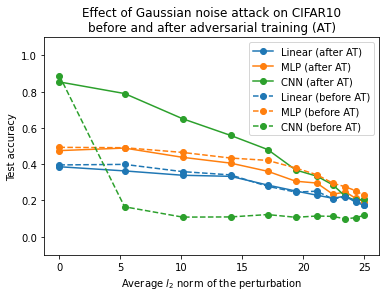

In [ ]:
df = pd.read_csv('Post training Adversarial_Attacks_CIFAR10 [Gaussian Noise Attack].csv')
plt.plot(df['avg_l2_norm'],df['Linear_CIFAR10_test_accuray'],'o-')
plt.plot(df['avg_l2_norm'],df['MLP_CIFAR10_test_accuray'],'o-')
plt.plot(df['avg_l2_norm'],df['CNN_CIFAR10_test_accuray'],'o-')

df = pd.read_csv('Adversarial_Attacks_CIFAR10 [Gaussian Noise Attack].csv')
plt.plot(df['avg_l2_norm'],df['Linear_CIFAR10_test_accuray'],'o--', color = 'C0')
plt.plot(df['avg_l2_norm'],df['MLP_CIFAR10_test_accuray'],'o--', color = 'C1')
plt.plot(df['avg_l2_norm'],df['CNN_CIFAR10_test_accuray'],'o--', color = 'C2')

plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
plt.legend(['Linear (after AT)', 'MLP (after AT)','CNN (after AT)', \
            'Linear (before AT)', 'MLP (before AT)','CNN (before AT)'])
plt.title('Effect of Gaussian noise attack on CIFAR10\nbefore and after adversarial training (AT)')
plt.savefig('Post training Effect of Gaussian noise attack on CIFAR10 [l2 norm]', dpi=600)
plt.show()

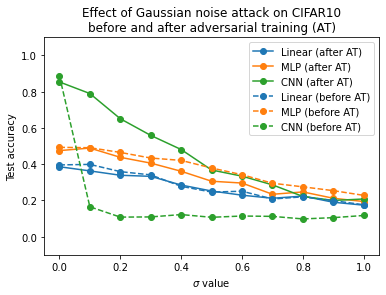

In [ ]:
df = pd.read_csv('Post training Adversarial_Attacks_CIFAR10 [Gaussian Noise Attack].csv')
plt.plot(df['sigma'],df['Linear_CIFAR10_test_accuray'],'o-')
plt.plot(df['sigma'],df['MLP_CIFAR10_test_accuray'],'o-')
plt.plot(df['sigma'],df['CNN_CIFAR10_test_accuray'],'o-')

df = pd.read_csv('Adversarial_Attacks_CIFAR10 [Gaussian Noise Attack].csv')
plt.plot(df['sigma'],df['Linear_CIFAR10_test_accuray'],'o--', color = 'C0')
plt.plot(df['sigma'],df['MLP_CIFAR10_test_accuray'],'o--', color = 'C1')
plt.plot(df['sigma'],df['CNN_CIFAR10_test_accuray'],'o--', color = 'C2')

plt.xlabel('$\sigma$ value')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
plt.legend(['Linear (after AT)', 'MLP (after AT)','CNN (after AT)', \
            'Linear (before AT)', 'MLP (before AT)','CNN (before AT)'])
plt.title('Effect of Gaussian noise attack on CIFAR10\nbefore and after adversarial training (AT)')
plt.savefig('Post training Effect of Gaussian noise attack on CIFAR10 [sigma]', dpi=600)
plt.show()